### Курсовой проект для курса "Python для Data Science"

### Материалы к проекту (файлы):
train.csv, test.csv

### Задание:
Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

### Целевая переменная:
Price

### Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

### Подключение библиотек и скриптов

In [1259]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

In [1260]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [1261]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Прогнозируемые значения')
    plt.ylabel('Истиные значения')
    plt.title('Прогнозирование обучающей выборки')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Прогнозируемые значения')
    plt.ylabel('Истиные значения')
    plt.title('Прогнозирование тестовой выборки')

    plt.show()

### Пути к директориям и файлам

In [1262]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
PREDICTIONS_PATH = 'predictions.csv '

### Загрузка данных

In [1263]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

### Разбор обучающего датасета

In [1264]:
print(train_df.shape)
print(test_df.shape)

(10000, 20)
(5000, 19)


Обучающий датасет имеет 10000 значений и 20 признаков

In [1265]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [1266]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

### Описание датасета :
    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры

По полученной информации видим что признаки LifeSquare и Healthcare_1 имеют пропуски в значениях(LifeSquare 2113 пропусков, Healthcare_1 4798 пропусков)

### Приведение типов
Приведем к строковому типу признаки Id и DistrictId 

Приведем HouseFloor, Floor и Rooms типу int32

In [1267]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df['HouseFloor'] = train_df['HouseFloor'].astype('int32')
train_df['Floor'] = train_df['Floor'].astype('int32')
train_df['Rooms'] = train_df['Rooms'].astype('int32')

### EDA

Построим графики распределение цены

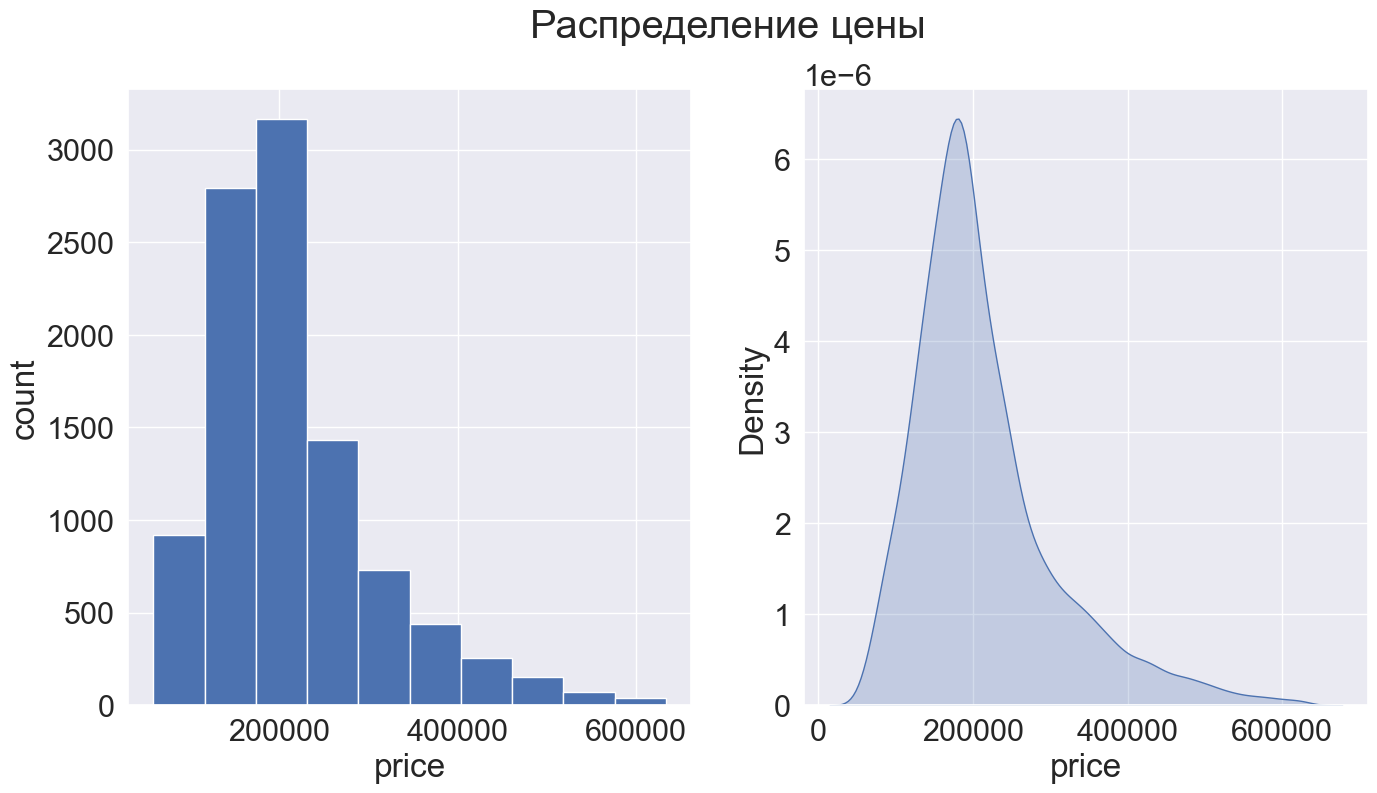

In [1268]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist()
plt.ylabel('count')
plt.xlabel('price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('price')

plt.suptitle('Распределение цены')
plt.show()

Количественные переменные

In [1269]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Номинативные переменные

In [1270]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [1271]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [1272]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [1273]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [1274]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов

Rooms

In [1275]:
train_df['Rooms']

0       2
1       3
2       2
3       2
4       1
       ..
9995    2
9996    1
9997    1
9998    2
9999    1
Name: Rooms, Length: 10000, dtype: int32

In [1276]:
train_df['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

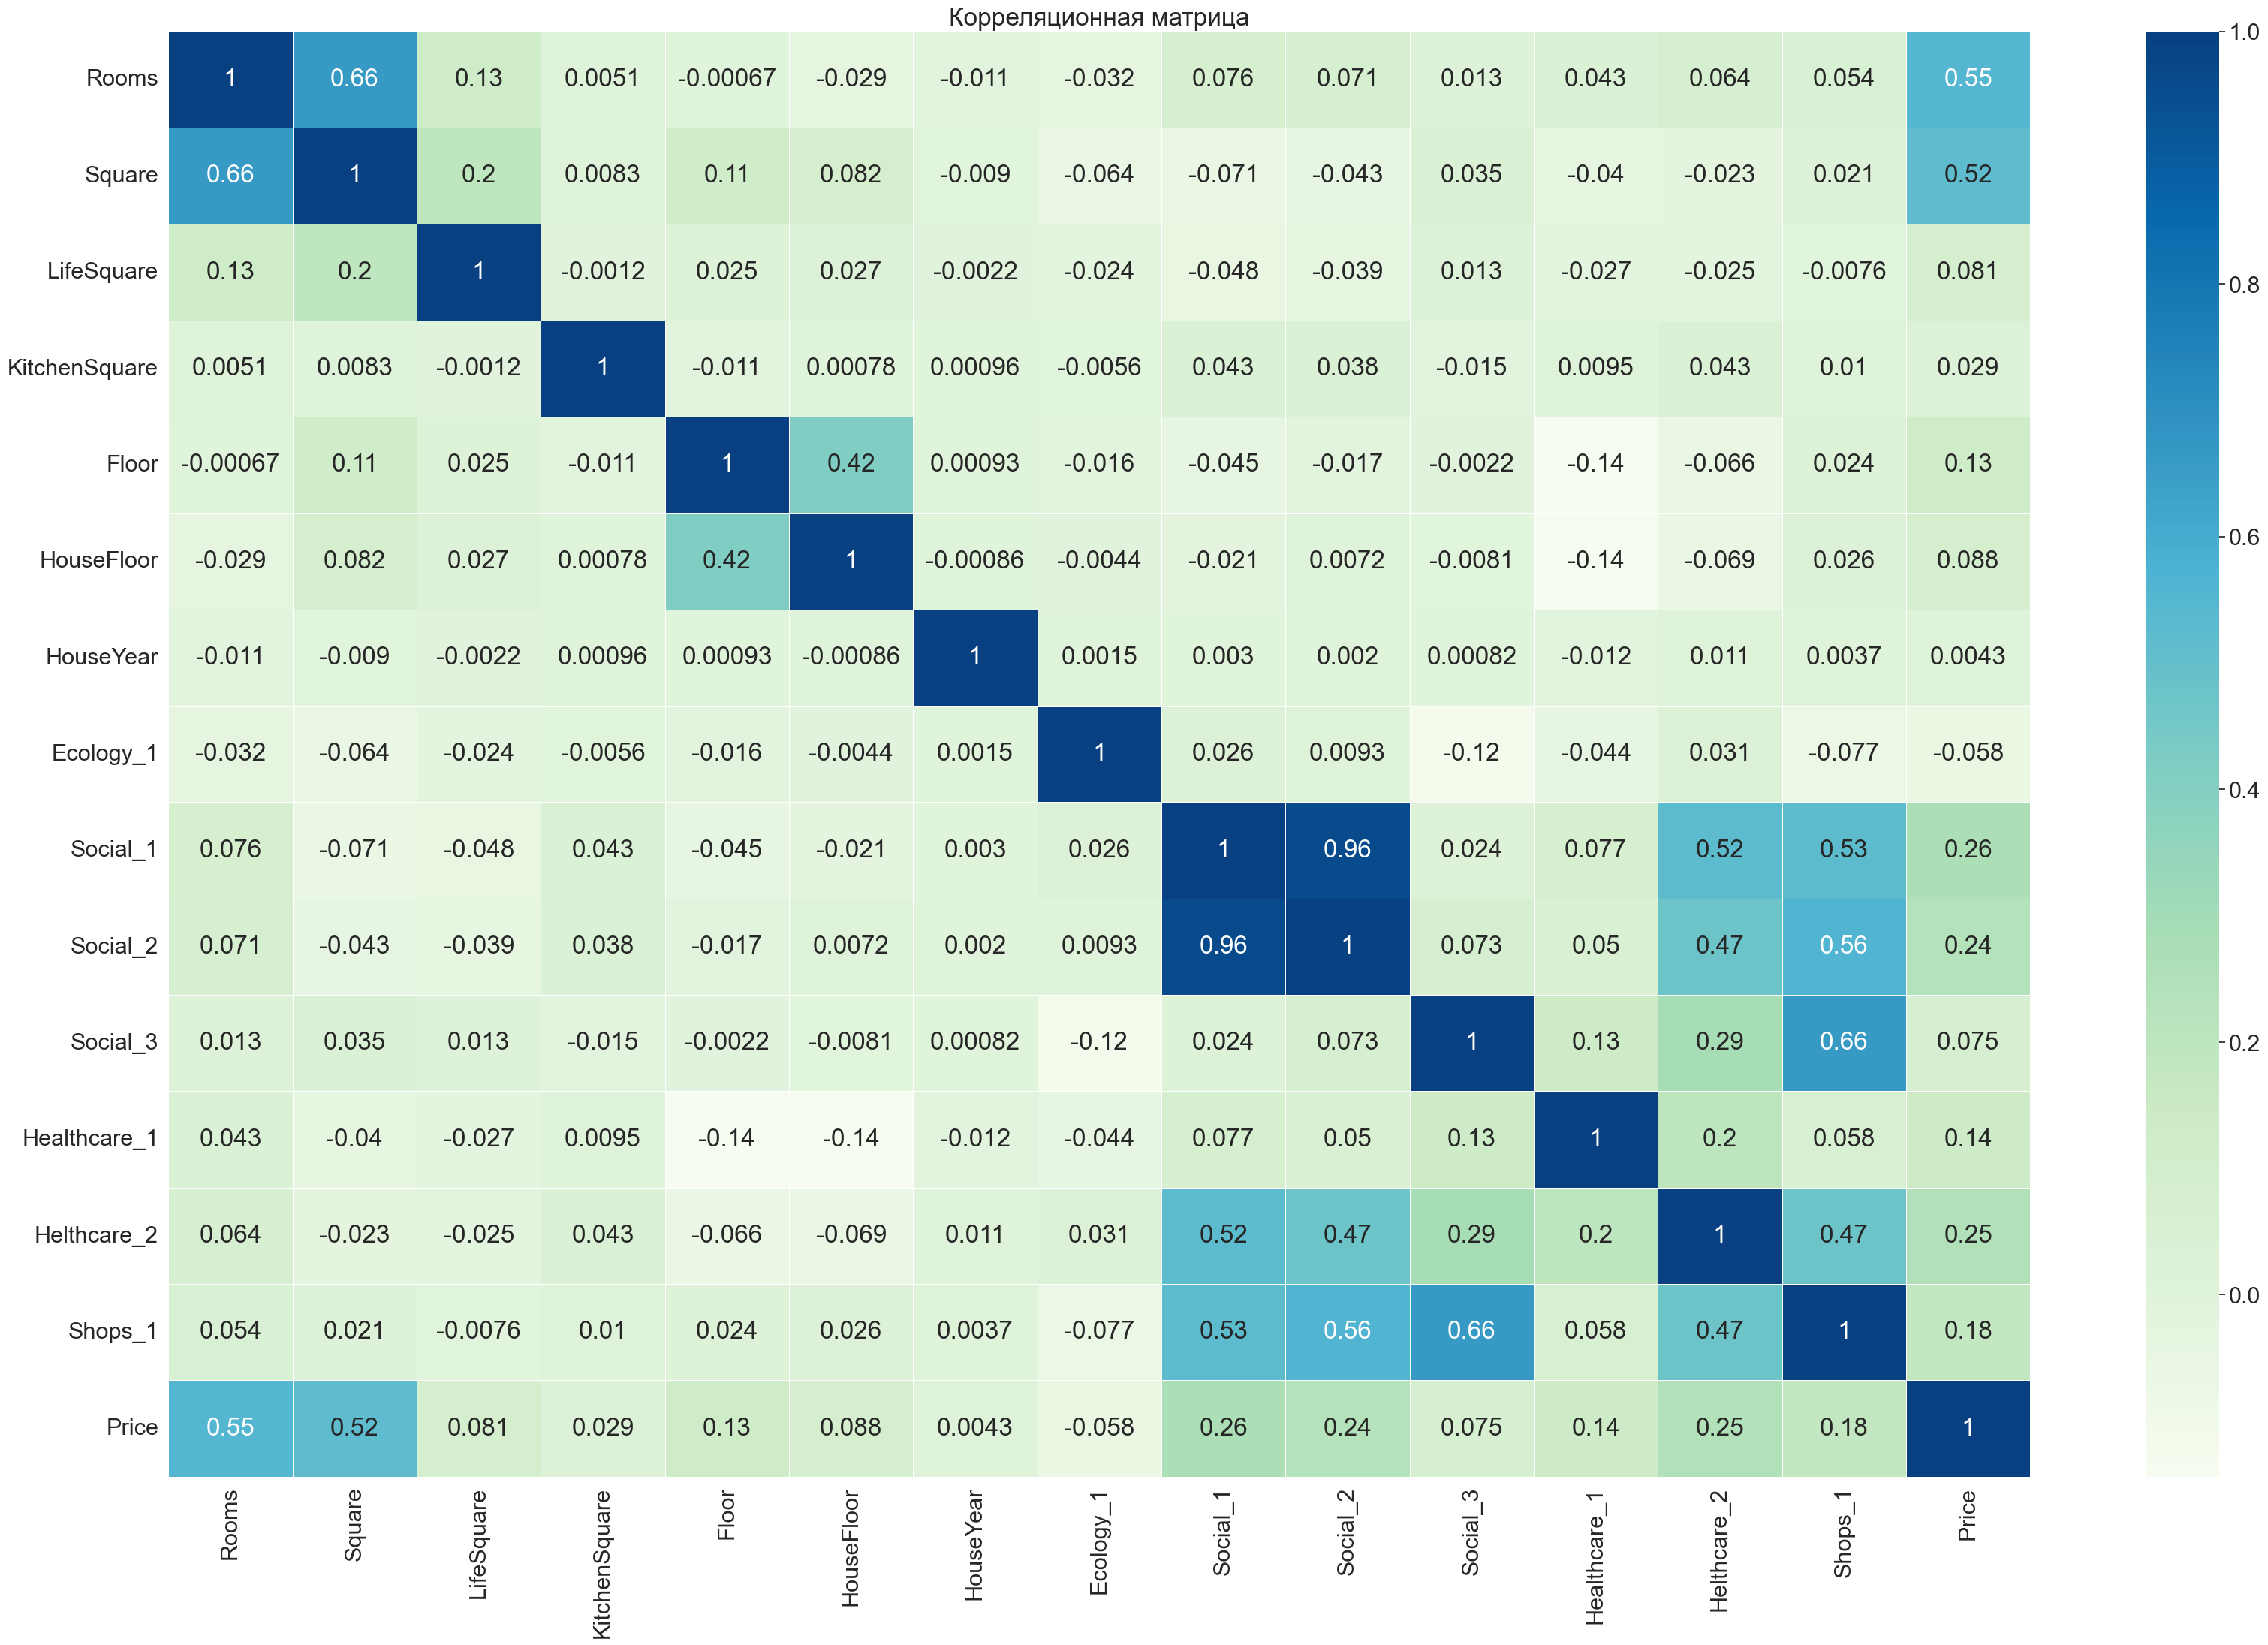

In [1277]:
plt.figure(figsize = (40,25))

sns.set(font_scale=2)
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Корреляционная матрица')
plt.show()

In [1278]:
# rooms_med = train_df['Rooms'].median()
# train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = rooms_med



from sklearn.linear_model import LinearRegression
lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(train_df[['Square','Price']], train_df['Rooms'], test_size=0.25, random_state=42)
lr.fit(X_train, y_train)
# y_pred = lr.predict(X_test)
# y_pred = np.round(y_pred)
# y_pred = y_pred.astype('int32')

# check_test = pd.DataFrame({
#     "y_test": y_test,
#     "y_pred": y_pred.flatten(),
# })

# R2 = r2(check_test['y_test'],check_test['y_pred'])
# R2

rooms = train_df.loc[train_df['Rooms'].isin([0, 10, 19]), ['Square','Price']]
y_pred = lr.predict(rooms)
y_pred = np.round(y_pred)
y_pred = y_pred.astype('int32')
rooms['new_rooms']=y_pred
rooms['new_rooms'][rooms['new_rooms'] == 0] =1

train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = rooms['new_rooms']
train_df




,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2,44.947953,29.197612,0.0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2,50.401785,30.476203,5.0,6,5,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1,41.521546,20.539216,9.0,13,13,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1,47.939008,NaN,1.0,12,16,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2,43.602562,33.840147,8.0,1,5,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


Работаем с выбросами признаков "LifeSquare" и "KitchenSquare"

In [1279]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.889100,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.813675,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,6.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [1280]:
lifesq_kitchsq_med = train_df.groupby('DistrictId')['LifeSquare','KitchenSquare'].mean()
temp = train_df.merge(lifesq_kitchsq_med, how='left',on='DistrictId')
temp = temp[['DistrictId','LifeSquare_x','KitchenSquare_x','LifeSquare_y','KitchenSquare_y']]

In [1281]:
temp['LifeSquare_x'].isna().sum()

2113

In [1282]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = temp['LifeSquare_y']
train_df.loc[train_df['LifeSquare'] < 2.0, 'LifeSquare'] = temp['LifeSquare_y']
train_df.loc[train_df['LifeSquare'] > 300, 'LifeSquare'] = temp['LifeSquare_y']
train_df.loc[train_df['KitchenSquare'] > 80, 'KitchenSquare'] = temp['KitchenSquare_y']
del temp 

In [1283]:
# lifesq_med = train_df['LifeSquare'].median()
# kitchsq_med = train_df['KitchenSquare'].median()
# train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = lifesq_med
# train_df.loc[train_df['LifeSquare'] < 2.0, 'LifeSquare'] = lifesq_med
# train_df.loc[train_df['LifeSquare'] > 300, 'LifeSquare'] = lifesq_med
# train_df.loc[train_df['KitchenSquare'] < 5, 'KitchenSquare'] = kitchsq_med
# train_df.loc[train_df['KitchenSquare'] > 80, 'KitchenSquare'] = kitchsq_med

HouseFloor, Floor

In [1284]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = 1

In [1285]:
ind = train_df[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[ind, 'Floor'] = train_df.loc[ind, 'HouseFloor']

HouseYear

In [1286]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

Работаем с выбросами признака "Square"

In [1287]:
square_med = train_df['Square'].median()
train_df.loc[train_df['Square'] < 16, 'Square'] = square_med
train_df.loc[train_df['Square'] > 400, 'Square'] = square_med

Healthcare_1

In [1288]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  int32  
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int32  
 7   HouseFloor     10000 non-null  int32  
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [1289]:
model = RandomForestRegressor(n_estimators=100,max_depth= 12, random_state = 42)
temp = train_df.copy()
temp = temp.dropna(axis=0,subset='Healthcare_1')
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
                'Floor','HouseFloor','HouseYear','Price']
X = temp[feature_names]
y = temp['Healthcare_1']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=42)

scaler = StandardScaler()

model.fit(scaler.fit_transform(X_train),y_train)

y_pred = model.predict(scaler.transform(X_test))
check_test = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred.flatten(),
})

R2 = r2(check_test['y_test'],check_test['y_pred'])
R2

0.6426694339631056

Найдем индексы, где Healthcare_1 это Nan

In [1290]:
ind = train_df[train_df['Healthcare_1'].isnull()].index
train_df.loc[ind, 'Healthcare_1']=model.predict(scaler.transform(train_df.loc[ind,feature_names]))

In [1291]:
#train_df.drop('Healthcare_1', axis=1, inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  int32  
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int32  
 7   HouseFloor     10000 non-null  int32  
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### Построение новых признаков

Преобразуем категориальные признаки "Ecology_2", "Ecology_3", "Shops_2" в бинарные

In [1292]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

Healthcare_1

Вычисляем "m_2_Price" - стоимость квадратного метра общей площади

In [1293]:
train_df['m_2_Price'] = train_df['Price'] / train_df['Square']
#test_df['m_2_Price'] = test_df['Price'] / test_df['Square']

На его основе создаем новые признаки m_2_MedPriceByDistrict - медианная стоимость квадратного метра в зависимости от района и m_2_MedPriceByHouseYear - медианная стоимость квадратного метра в зависимости от возраста дома

In [1294]:
m_2_MedPriceByDistrict = train_df.groupby(['DistrictId'], as_index=False).agg({'m_2_Price':'median'})\
                    .rename(columns={'m_2_Price':'m_2_MedPriceByDistrict'})
m_2_MedPriceByHouseYear = train_df.groupby(['HouseYear'], as_index=False).agg({'m_2_Price':'median'})\
                    .rename(columns={'m_2_Price':'m_2_MedPriceByHouseYear'})

Добавляем новые признаки к датасету

In [1295]:
train_df = train_df.merge(m_2_MedPriceByDistrict, on=['DistrictId'], how='left')
train_df = train_df.merge(m_2_MedPriceByHouseYear, on=['HouseYear'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_Price,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,...,0,11,B,184966.930730,1,1,1,3854.958571,4358.274853,4473.255408
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,...,1,16,B,300009.450063,1,1,1,4567.491245,4437.304072,4317.685445
2,4765,53,2,44.947953,29.197612,0.0,8,12,1968,0.049637,...,1,3,B,220925.908524,1,1,1,4915.149522,4845.919064,4429.204254
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,...,0,5,B,175616.227217,1,1,1,3291.591637,2949.975415,2901.326376
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,...,2,4,B,150226.531644,1,1,1,3788.892642,3992.031265,4367.263383


In [1296]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_Price,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.889100,56.228457,38.328943,5.839323,7.727300,12.63630,1984.872400,0.118858,24.687000,5352.157400,...,1192.848811,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500,3891.739716,3927.295723,3780.144330
std,0.813675,19.058793,16.582465,4.792071,5.267344,6.72767,18.416347,0.119025,17.532614,4006.799803,...,899.806762,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139,1251.728243,997.479341,762.735269
min,1.000000,16.117154,2.014454,0.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,168.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,752.588644,2273.498737,2764.147132
25%,1.000000,41.800063,26.042897,1.000000,4.000000,9.00000,1974.000000,0.017647,6.000000,1564.000000,...,540.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000,2916.973642,2938.048239,2901.326376
50%,2.000000,52.513310,36.946446,6.000000,7.000000,13.00000,1977.000000,0.075424,25.000000,5285.000000,...,1015.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000,3907.999942,4134.353749,4285.794408
75%,2.000000,65.889736,46.815845,9.000000,11.000000,17.00000,2001.000000,0.195781,36.000000,7227.000000,...,1713.841453,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000,4690.526670,4562.026777,4409.376396
max,6.000000,275.645284,263.542020,116.555556,42.000000,117.00000,2020.000000,0.521867,74.000000,19083.000000,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,11854.652892,8700.768533,7823.822055


Построим Корреляционную матрицу

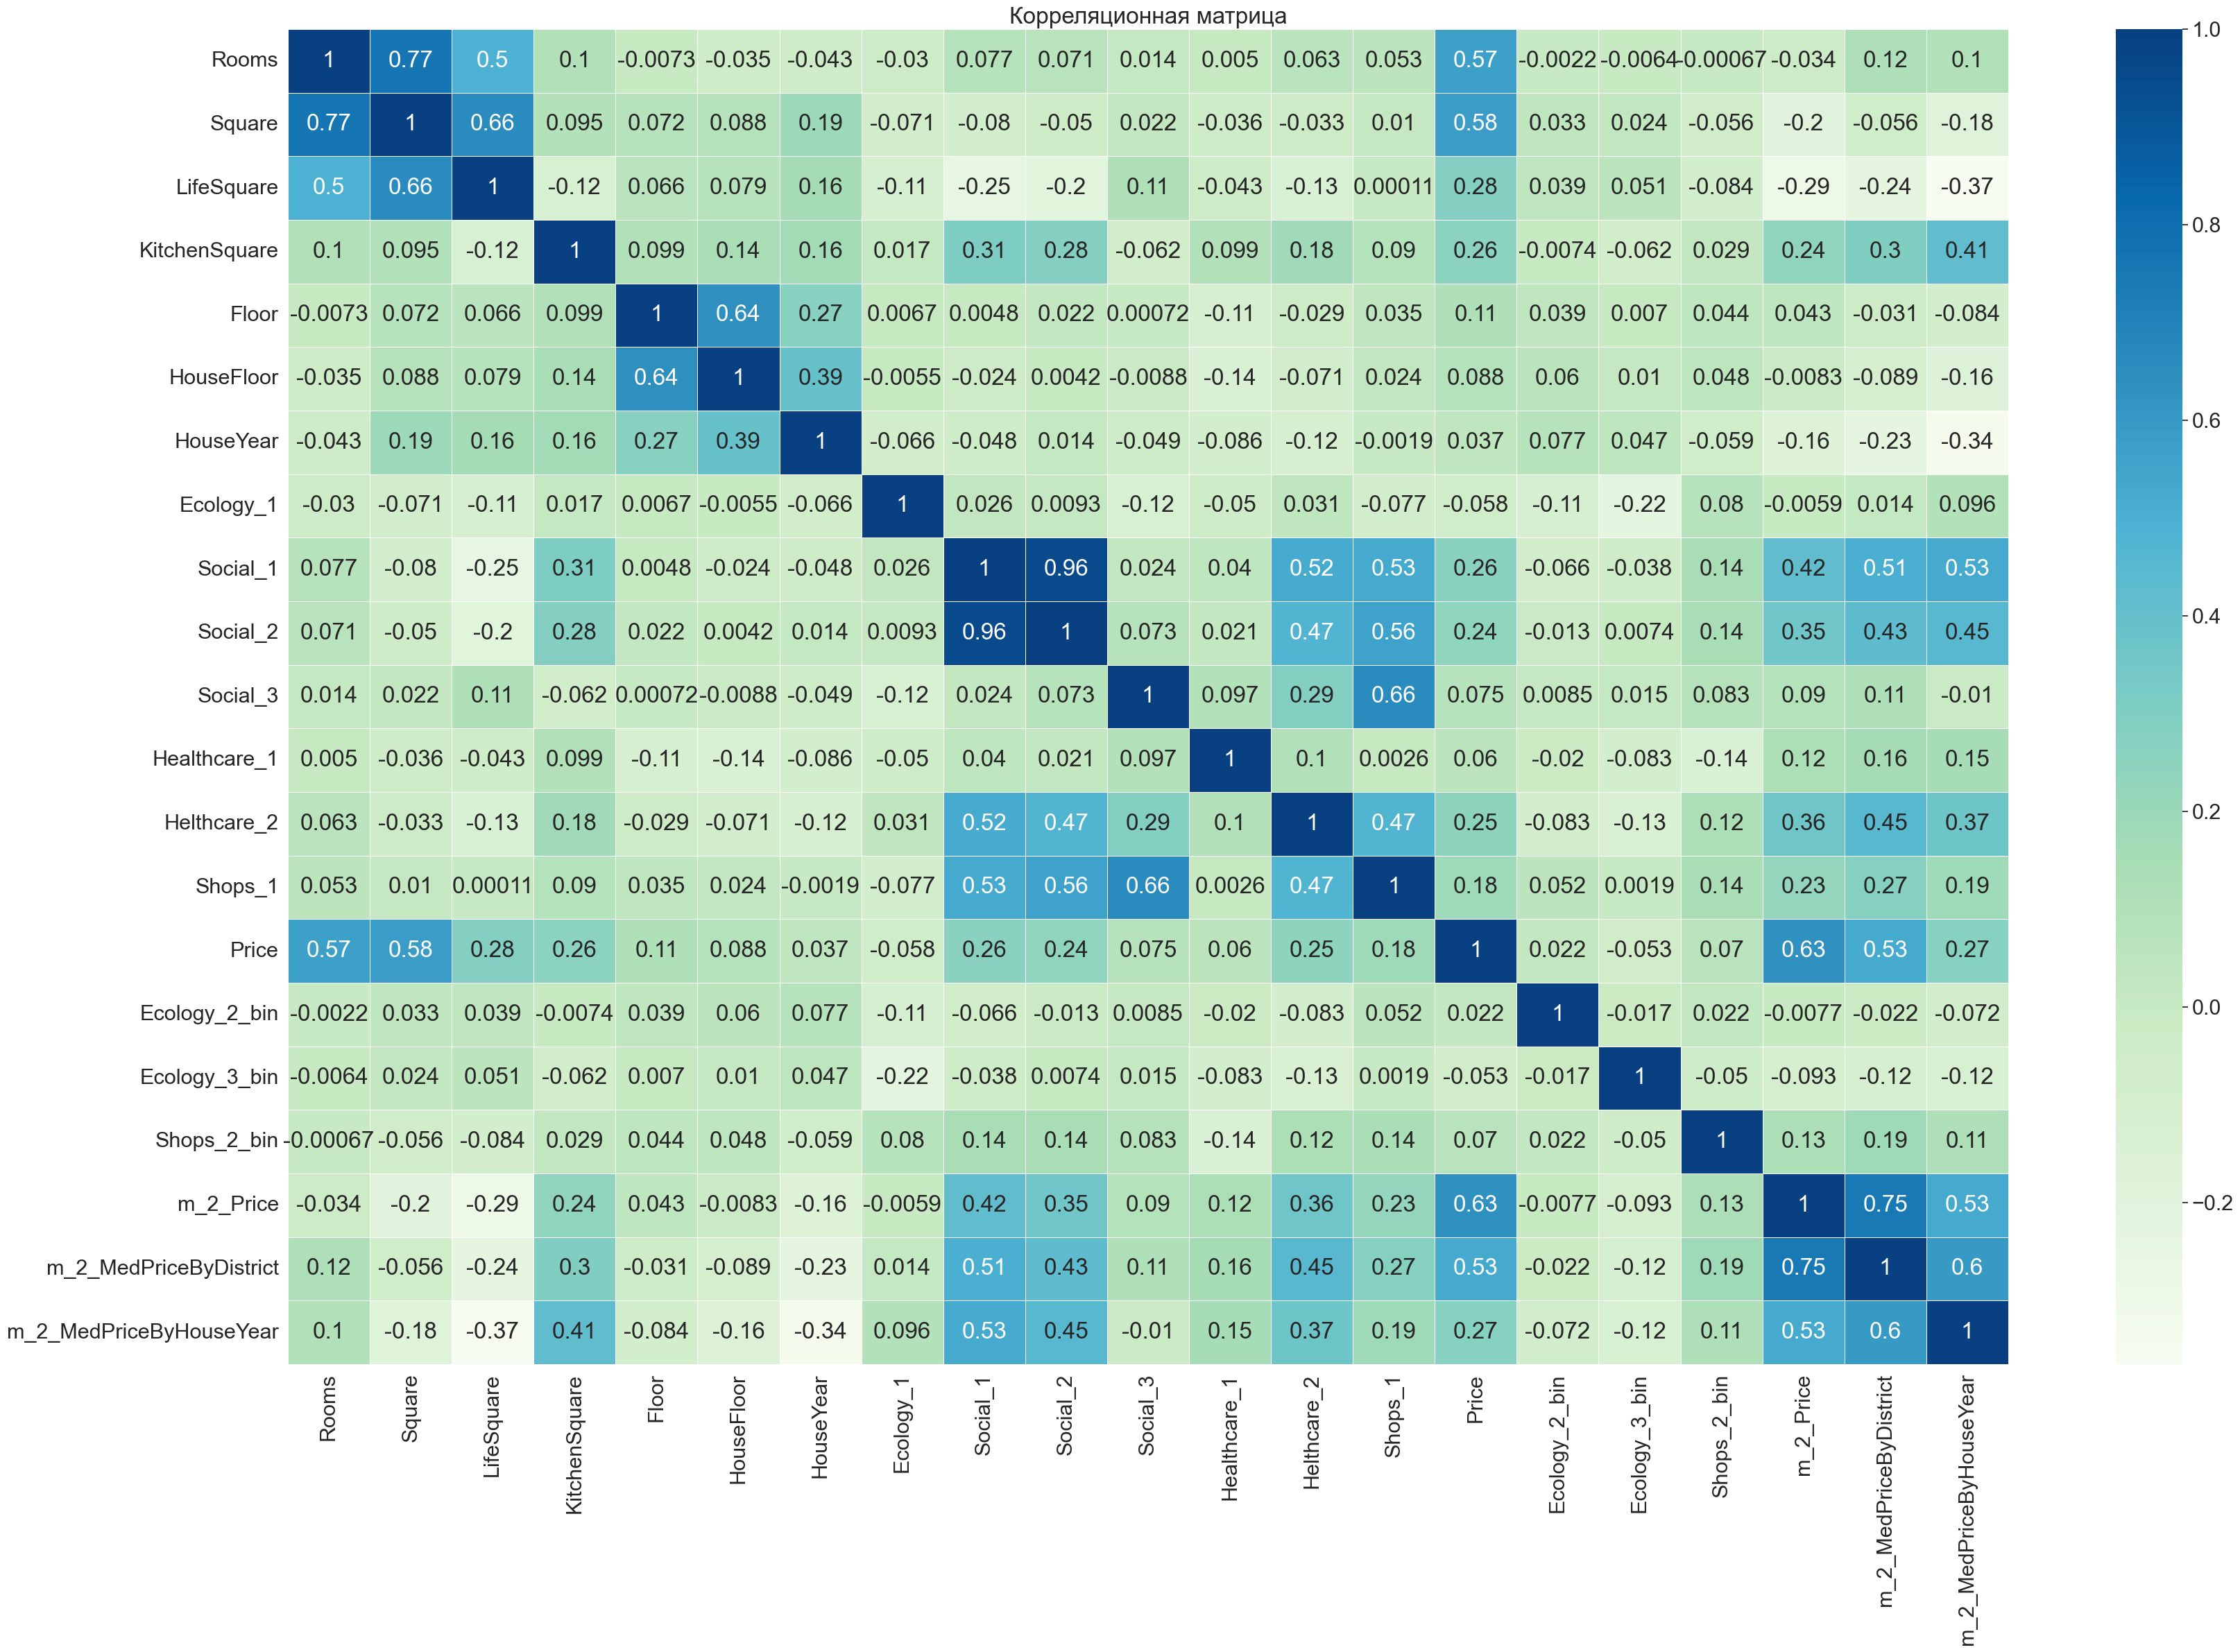

In [1297]:
plt.figure(figsize = (40,25))

sns.set(font_scale=2)
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Корреляционная матрица')
plt.show()

### Отбираем признаки для модели

In [1298]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                 'm_2_MedPriceByDistrict', 'm_2_MedPriceByHouseYear', 
                 'Ecology_1','Social_1', 'Social_3', 'Helthcare_2', 'Shops_1', 
                 'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin',]
target_name = 'Price'

In [1299]:
df = train_df[feature_names + [target_name]]
df.head(10)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,2,47.981561,29.442751,6.0,7,9,1969,4358.274853,4473.255408,0.089040,33,5,0,11,1,1,1,184966.930730
1,3,65.683640,40.049543,8.0,7,9,1978,4437.304072,4317.685445,0.000070,46,1,1,16,1,1,1,300009.450063
2,2,44.947953,29.197612,0.0,8,12,1968,4845.919064,4429.204254,0.049637,34,0,1,3,1,1,1,220925.908524
3,2,53.352981,52.731512,9.0,8,17,1977,2949.975415,2901.326376,0.437885,23,3,0,5,1,1,1,175616.227217
4,1,39.649192,23.776169,7.0,11,12,1976,3992.031265,4367.263383,0.012339,35,1,2,4,1,1,1,150226.531644
5,3,80.384479,46.683720,12.0,5,17,2011,4736.631611,3085.925983,0.309479,35,4,0,6,1,1,1,215898.447742
6,2,62.254114,37.160377,7.0,3,5,1960,5445.489427,4471.625922,0.460556,20,14,1,5,1,1,1,296021.204377
7,2,80.312926,44.251401,0.0,1,1,1977,3319.318045,2901.326376,0.075779,6,3,0,2,1,1,1,221244.156664
8,2,64.511437,45.952649,1.0,9,17,1977,3251.647396,2901.326376,0.007122,1,0,0,1,1,1,1,229102.795999
9,1,46.461409,18.915552,8.0,13,17,2014,2273.498737,2793.739365,0.075779,6,3,0,2,1,1,1,95380.220993


### Разбиение на train и test

In [1300]:
X = df[feature_names]
y = df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.67, shuffle=True, random_state=42)

Масштабируем признаки

In [1301]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

### Построение модели

Обучение

In [1302]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', random_state=21)

Оценка модели

Train R2:	0.967
Test R2:	0.742


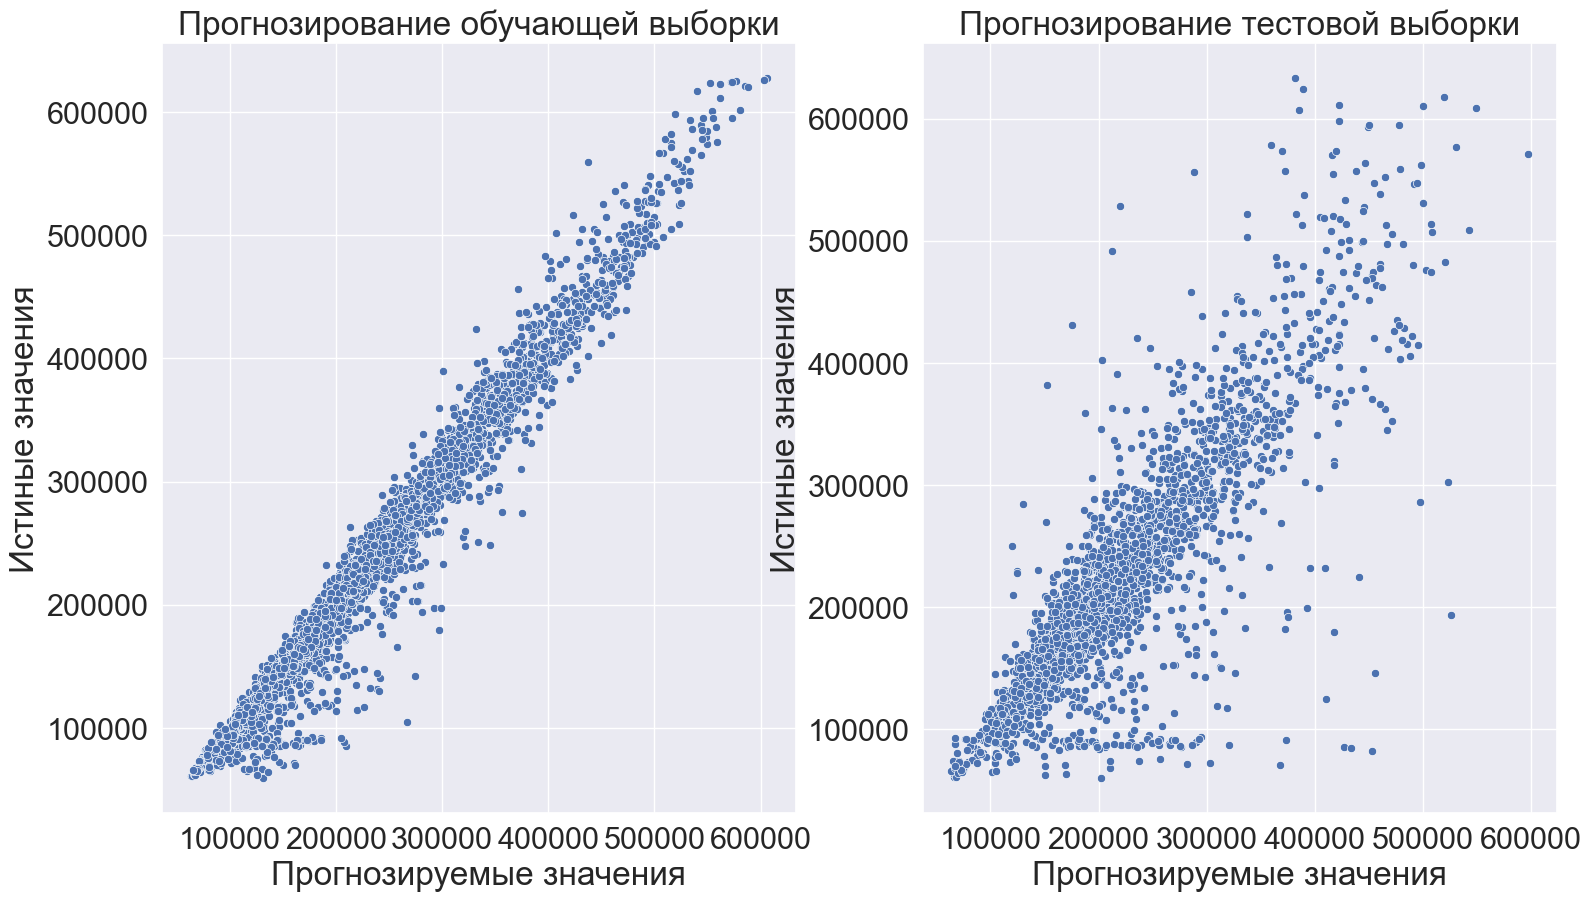

In [1303]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Кросс-валидация

In [1304]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.76883344, 0.71533287, 0.75582643])

In [1305]:
cv_score.mean()

0.7466642472490846

### Важность признаков

In [1306]:
feature_importances = pd.DataFrame(zip(feature_names, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.426705
7,m_2_MedPriceByDistrict,0.340526
8,m_2_MedPriceByHouseYear,0.033693
2,LifeSquare,0.027269
0,Rooms,0.025455
10,Social_1,0.023065
6,HouseYear,0.021195
4,Floor,0.019698
9,Ecology_1,0.018767
3,KitchenSquare,0.017178


### Прогнозирование на тестовом датасете

In [1307]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


Смотрим размер датасета

In [1308]:
test_df.shape

(5000, 19)

Смотрим информацию датасета

In [1309]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Приводим Id и DistrictId к строковому типу

In [1310]:
test_df['Id'] = train_df['Id'].astype(str)
test_df['DistrictId'] = train_df['DistrictId'].astype(str)

Смотрим количественные переменные

In [1311]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


### Добавляем новые фичи

In [1312]:
test_df['Ecology_2'].value_counts()
test_df['Ecology_3'].value_counts()
test_df['Shops_2'].value_counts()

B    4588
A     412
Name: Shops_2, dtype: int64

In [1313]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [1314]:
test_df = test_df.merge(m_2_MedPriceByDistrict, on=['DistrictId'], how='left')
test_df = test_df.merge(m_2_MedPriceByHouseYear, on=['HouseYear'], how='left')

### Работа с пропусками и выбросами

In [1315]:
test_df.loc[test_df['Rooms'].isin([0]), 'Rooms'] = rooms_med

In [1316]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       5000 non-null   object 
 1   DistrictId               5000 non-null   object 
 2   Rooms                    5000 non-null   float64
 3   Square                   5000 non-null   float64
 4   LifeSquare               3959 non-null   float64
 5   KitchenSquare            5000 non-null   float64
 6   Floor                    5000 non-null   int64  
 7   HouseFloor               5000 non-null   float64
 8   HouseYear                5000 non-null   int64  
 9   Ecology_1                5000 non-null   float64
 10  Ecology_2                5000 non-null   object 
 11  Ecology_3                5000 non-null   object 
 12  Social_1                 5000 non-null   int64  
 13  Social_2                 5000 non-null   int64  
 14  Social_3                

In [1317]:
temp = test_df.merge(lifesq_kitchsq_med, how='left',on='DistrictId')
temp = temp[['DistrictId','LifeSquare_x','KitchenSquare_x','LifeSquare_y','KitchenSquare_y']]
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = temp['LifeSquare_y']
test_df.loc[test_df['LifeSquare'] < 2.0, 'LifeSquare'] = temp['LifeSquare_y']
test_df.loc[test_df['LifeSquare'] > 300, 'LifeSquare'] = temp['LifeSquare_y']

test_df.loc[test_df['KitchenSquare'] > 80, 'KitchenSquare'] = temp['KitchenSquare_y']
del temp 

In [1318]:
# test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = lifesq_med
# test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare'] = lifesq_med
# test_df.loc[test_df['LifeSquare'] > 200, 'LifeSquare'] = lifesq_med
# test_df.loc[test_df['KitchenSquare'] < 5, 'KitchenSquare'] = kitchsq_med
#test_df.loc[test_df['KitchenSquare'] > 80, 'KitchenSquare'] = kitchsq_med

In [1319]:
test_df.loc[test_df['Square'] < 16, 'Square'] = square_med
test_df.loc[test_df['Square'] > 400, 'Square'] = square_med

In [1320]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = hfloor_med
ind = test_df[test_df['Floor'] > test_df['HouseFloor']].index
test_df.loc[ind, 'Floor'] = test_df.loc[ind, 'HouseFloor']

In [1321]:
test_df.loc[test_df['m_2_MedPriceByDistrict'].isnull(), 'm_2_MedPriceByDistrict'] =\
                    m_2_MedPriceByDistrict['m_2_MedPriceByDistrict'].median()
test_df.loc[(test_df['m_2_MedPriceByHouseYear'].isnull()) & (test_df['HouseYear'] < 1950), 
                     'm_2_MedPriceByHouseYear'] =\
                      m_2_MedPriceByHouseYear.loc[m_2_MedPriceByHouseYear['HouseYear'] < 1950,
                                                  'm_2_MedPriceByHouseYear'].median()
test_df.loc[(test_df['m_2_MedPriceByHouseYear'].isnull()) & (test_df['HouseYear'] >= 1990), 
                     'm_2_MedPriceByHouseYear'] =\
                      m_2_MedPriceByHouseYear.loc[m_2_MedPriceByHouseYear['HouseYear'] >= 1990,
                                                  'm_2_MedPriceByHouseYear'].median()
test_df.loc[(test_df['m_2_MedPriceByHouseYear'].isnull()) & (test_df['HouseYear'] >= 1950) &\
                    (test_df['HouseYear'] < 1990), 'm_2_MedPriceByHouseYear'] =\
                      m_2_MedPriceByHouseYear.loc[(m_2_MedPriceByHouseYear['HouseYear'] >= 1950) & \
                                                  (m_2_MedPriceByHouseYear['HouseYear'] < 1990),
                                                  'm_2_MedPriceByHouseYear'].median()

Масштабируем признаки

In [1322]:
# #!!!
# stand_features = scaler.fit_transform(test_df[feature_names])
# test_df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)

Предсказываем цены для тестового датасета

In [1323]:
X_test = test_df[feature_names]
X_test = scaler.transform(X_test)

In [1324]:
y_test_preds = rf_model.predict(X_test)

In [1325]:
y_test_preds

array([201874.57905878, 226259.01199452, 191227.59162723, ...,
       318068.43678813, 419463.70978123, 160098.42564737])

Сохраняем результаты

In [1326]:
test_df['Price'] = y_test_preds
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear,Price
0,14038,35,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,NaN,0,0,B,1,1,1,4358.274853,4285.794408,201874.579059
1,15053,41,2.0,69.263183,32.020587,1.0,1,1.0,1977,0.075779,...,NaN,0,2,B,1,1,1,4437.304072,2901.326376,226259.011995
2,4765,53,1.0,52.513310,15.948246,12.0,2,5.0,1909,0.000000,...,4702.0,5,5,B,1,1,1,4845.919064,5523.532106,191227.591627
3,5809,58,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,NaN,3,3,B,1,1,1,2949.975415,4401.624751,243194.342263
4,10783,99,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,NaN,0,0,A,1,1,0,3992.031265,3050.413766,158168.494695


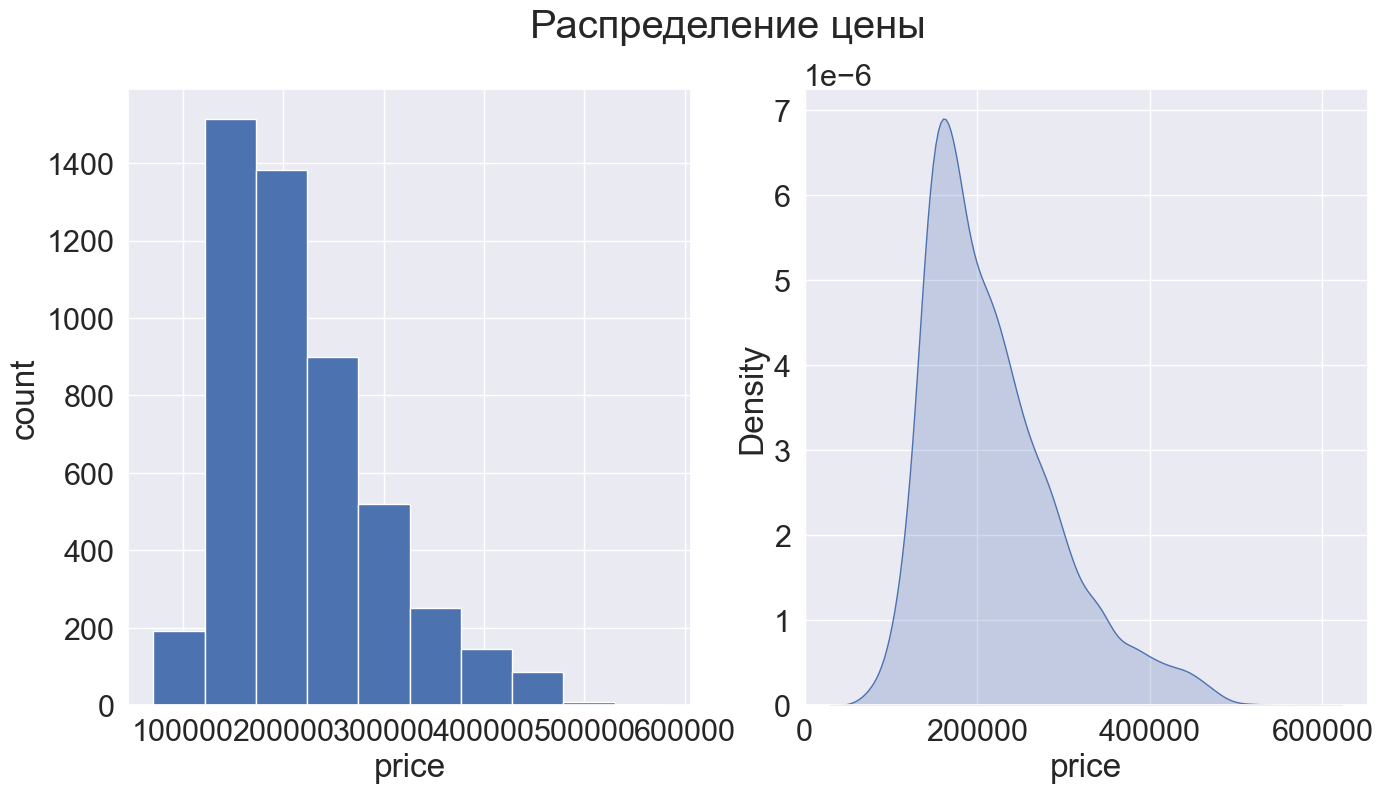

In [1327]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
test_df['Price'].hist()
plt.ylabel('count')
plt.xlabel('price')

plt.subplot(122)
sns.kdeplot(test_df['Price'], shade=True, legend=False)
plt.xlabel('price')

plt.suptitle('Распределение цены')
plt.show()

In [1328]:
test_df.to_csv(PREDICTIONS_PATH, columns=['Id', 'Price'], index=False, encoding='utf-8')